In [0]:
from __future__ import print_function

import keras
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout, BatchNormalization, AveragePooling2D, Concatenate

import numpy as np
from keras.datasets import cifar10, mnist, fashion_mnist
import skimage.transform



class GoogleNet:

    def __init__(self, input_shape, nlabels):
        self._input_shape = input_shape
        self._nlabels = nlabels
        self._model = self.initialize_model()

    def model(self):
        return self._model

    def _inception(self, in_, filters):
        #
        p1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(in_)

        p2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(in_)
        p2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(p2)

        p3 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(in_)
        p3 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(p3)

        p4 = MaxPooling2D(pool_size=(1,1), strides=1, padding='same')(in_)
        p3 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(p4)
        return Concatenate(axis=-1)([p1, p2, p3, p4])

    def _output(self, in_, name=None):
        o = AveragePooling2D(pool_size=(1,1), strides=1, padding='valid')(in_)
        o = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(o)
        o = Flatten()(o)
        o = Dense(units=256, activation='relu')(o)
        o = Dropout(0.5)(o)
        o = Dense(units=self._nlabels, activation='softmax', name=name)(o)
        return o

    def initialize_model(self):
        input_ = Input(shape=self._input_shape)

        ##
        seq = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(input_)
        seq = MaxPooling2D(pool_size=(1,1), strides=2, padding='same')(seq)
        seq = BatchNormalization()(seq)

        ##
        seq = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(seq)
        seq = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(seq)
        seq = BatchNormalization()(seq)
        seq = MaxPooling2D(pool_size=(1,1), strides=2, padding='same')(seq)

        ##
        seq = self._inception(seq, [ 64,  (96,128), (16,32), 32])
        seq = self._inception(seq, [128, (128,192), (32,96), 64]) 
        seq = MaxPooling2D(pool_size=(1,1), strides=2, padding='same')(seq)

        ##
        seq = self._inception(seq, [ 192,  (96,208), (16,48), 64])
        out1 = self._output(seq, name='out1')
        seq = self._inception(seq, [ 160,  (112,224), (24,64), 64])
        seq = self._inception(seq, [ 128,  (128,256), (24,64), 64])
        seq = self._inception(seq, [ 112,  (144,288), (32,64), 64])
        out2 = self._output(seq, name='out2')
        seq = self._inception(seq, [ 256,  (160,320), (32,128), 128])
        seq = MaxPooling2D(pool_size=(1,1), strides=2, padding='same')(seq)

        ##
        seq = self._inception(seq, [ 256,  (160,320), (32,128), 128])
        seq = self._inception(seq, [ 384,  (192,384), (48,128), 128])
        seq = AveragePooling2D(pool_size=(1,1), strides=1, padding='valid')(seq)

        ##
        seq = Flatten()(seq)
        seq = Dropout(0.5)(seq)
        seq = Dense(units=256, activation='linear')(seq)
        seq = Dense(units=self._nlabels, activation='softmax', name='out')(seq)

        output_ = seq

        model = Model(input_, [output_, out1, out2])
        model.compile(
                loss = keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(0.0001),
                metrics=['accuracy'],)
        return model



class VGG16:
    def __init__(self, input_shape, nlabels):
        self._input_shape = input_shape
        self._nlabels = nlabels
        self._model = self.initialize_model()

    def model(self):
        return self._model

    def initialize_model(self):
        print(self._input_shape)
        input_ = Input(shape=self._input_shape)
        
        #### 
        seq = Conv2D(64, (3,3), padding="same", activation="relu",
                name="b1.conv1")(input_)
        seq = Conv2D(64, (3,3), padding="same", activation="relu",
                name="b1.conv2")(seq)
        seq = MaxPooling2D((2,2), strides=(2, 2), name="b1.pool")(seq)

        ###
        seq = Conv2D(128, (3,3), padding="same", activation="relu",
                name="b2.conv1")(seq)
        seq = Conv2D(128, (3,3), padding="same", activation="relu",
                name="b2.conv2")(seq)
        seq = MaxPooling2D((2,2), strides=(2, 2), name="b2.pool")(seq)

        ###
        seq = Conv2D(256, (3,3), padding="same", activation="relu",
                name="b3.conv1")(seq)
        seq = Conv2D(256, (3,3), padding="same", activation="relu",
                name="b3.conv2")(seq)
        seq = Conv2D(256, (3,3), padding="same", activation="relu",
                name="b3.conv3")(seq)
        seq = MaxPooling2D((2,2), strides=(2, 2), name="b3.pool")(seq)

        ###
        seq = Conv2D(512, (3,3), padding="same", activation="relu",
                name="b4.conv1")(seq)
        seq = Conv2D(512, (3,3), padding="same", activation="relu",
                name="b4.conv2")(seq)
        seq = Conv2D(512, (3,3), padding="same", activation="relu",
                name="b4.conv3")(seq)
        seq = MaxPooling2D((2,2), strides=(2, 2), name="b4.pool")(seq)

        ### 
        seq = Conv2D(512, (3,3), padding="same", activation="relu",
                name="b5.conv1")(seq)
        seq = Conv2D(512, (3,3), padding="same", activation="relu",
                name="b5.conv2")(seq)
        seq = Conv2D(512, (3,3), padding="same", activation="relu",
                name="b5.conv3")(seq)
        # seq = MaxPooling2D((2,2), strides=(2, 2), name="b5.pool")(seq)
        seq = MaxPooling2D((1,1), strides=(2, 2), name="b5.pool")(seq)

        seq = Flatten(name="flatten")(seq)
        seq = Dense(units=4096,activation="relu", name="dense1")(seq)
        seq = Dense(units=4096,activation="relu", name="dense2")(seq)
        seq = Dense(units=self._nlabels, activation="softmax", name="dense_softmax")(seq)

        output_ = seq

        model = Model(input_, output_)
        model.compile(
                loss = keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(0.0001),
                metrics=['accuracy'],)
        return model




    



### VGG16
def vgg16_mnist():
    nlabels = 10
    # load dataset
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    y_train = keras.utils.to_categorical(y_train, nlabels)
    y_test = keras.utils.to_categorical(y_test, nlabels)

    x_train= x_train/ 255.
    x_test= x_test/ 255.
    x_train= x_train.astype('float32')
    x_test= x_test.astype('float32')

    # reshape to 3 dims
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

    input_shape = x_train.shape

    # initialize the model
    vgg = VGG16(input_shape[1:], nlabels)

    vgg.model().summary()

    hist = vgg.model().fit(x_train, y_train, batch_size=100, epochs=20, validation_split=0.2)
    res_eval = vgg.model().evaluate(x_test, y_test, batch_size=100)
    
    return (vgg, hist.history, res_eval)


def vgg16_cifar10():
    nlabels = 10
    # load dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()


    y_train = keras.utils.to_categorical(y_train, nlabels)
    y_test = keras.utils.to_categorical(y_test, nlabels)

    x_train= x_train/ 255.
    x_test= x_test/ 255.
    x_train= x_train.astype('float32')
    x_test= x_test.astype('float32')

    input_shape = x_train.shape

    # initialize the model
    vgg = VGG16(input_shape[1:], nlabels)
    
    vgg.model().summary()

    hist = vgg.model().fit(x_train, y_train, batch_size=100, epochs=20, validation_split=0.2)
    res_eval = vgg.model().evaluate(x_test, y_test, batch_size=100)
    
    return (vgg, hist.history, res_eval)



### GOOGLENET

def googlenet_mnist():
    nlabels = 10
    # load dataset
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    y_train = keras.utils.to_categorical(y_train, nlabels)
    y_test = keras.utils.to_categorical(y_test, nlabels)

    x_train= x_train/ 255.
    x_test= x_test/ 255.
    x_train= x_train.astype('float32')
    x_test= x_test.astype('float32')

    # reshape to 3 dims
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

    input_shape = x_train.shape

    # initialize the model
    googlenet = GoogleNet(input_shape[1:], nlabels)

    googlenet.model().summary()

    hist = googlenet.model().fit(x_train, [y_train, y_train, y_train], batch_size=100, epochs=20, validation_split=0.2)
    res_eval = googlenet.model().evaluate(x_test, [y_test, y_test, y_test], batch_size=100)
    
    return (googlenet, hist.history, res_eval)

def googlenet_cifar10():
    nlabels = 10
    # load dataset
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    y_train = keras.utils.to_categorical(y_train, nlabels)
    y_test = keras.utils.to_categorical(y_test, nlabels)

    x_train= x_train/ 255.
    x_test= x_test/ 255.
    x_train= x_train.astype('float32')
    x_test= x_test.astype('float32')

    input_shape = x_train.shape

    # initialize the model
    googlenet = GoogleNet(input_shape[1:], nlabels)
    googlenet.model().summary()

    hist = googlenet.model().fit(x_train, [y_train, y_train, y_train], batch_size=100, epochs=20, validation_split=0.2)
    res_eval = googlenet.model().evaluate(x_test, [y_test, y_test, y_test], batch_size=100)
    
    return (googlenet, hist.history, res_eval)



In [0]:
import matplotlib.pyplot as plt


def plot_train(history):
    acc = history['out_accuracy']
    val_acc = history['val_out_accuracy']
    loss = history['out_loss']
    val_loss = history['val_out_loss']

    epochs_range = range(20)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


def print_evaluate(eval_value):
    print('eval loss : {}'.format(eval_value[1]))
    print('eval accuracy : {}'.format(eval_value[4]))


In [7]:
gn_m = googlenet_mnist()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 14, 14, 64)   3200        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 7, 7, 64)     0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 7, 7, 64)     256         max_pooling2d_14[0][0]           
____________________________________________________________________________________________

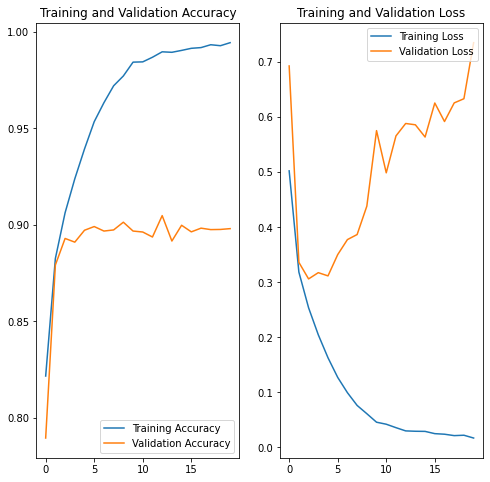

eval loss : 0.776521623134613
eval accuracy : 0.8928999900817871


In [23]:
plot_train(gn_m[1])
print_evaluate(gn_m[2])

In [25]:
gn_m[1]

{'loss': [1.6112477459013461,
  0.977674153012534,
  0.7774392236024141,
  0.6311060125939548,
  0.5033759915580353,
  0.39140397175215186,
  0.308457975431035,
  0.23835878423415124,
  0.18536073543170156,
  0.14100769300712274,
  0.128323753119912,
  0.10479179098911118,
  0.09010175601385223,
  0.08304195836293123,
  0.07979312166426097,
  0.06922101633996741,
  0.06696790397011985,
  0.05911878576031692,
  0.06205337459517371,
  0.047000012555872675],
 'out1_accuracy': [0.8011875,
  0.882625,
  0.9050417,
  0.9220833,
  0.937125,
  0.95102084,
  0.9619167,
  0.9700417,
  0.9772292,
  0.98214585,
  0.9836042,
  0.98775,
  0.9893542,
  0.99027085,
  0.9916875,
  0.9925625,
  0.992625,
  0.9937083,
  0.99289584,
  0.99508333],
 'out1_loss': [0.577151,
  0.33526248,
  0.26648036,
  0.2180387,
  0.17587945,
  0.13738802,
  0.10895758,
  0.08519051,
  0.065099545,
  0.050599296,
  0.04494949,
  0.035175953,
  0.03107858,
  0.027324354,
  0.024886262,
  0.02207069,
  0.021679195,
  0.0191

In [14]:
gn_c = googlenet_cifar10()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_178 (Conv2D)             (None, 16, 16, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 8, 8, 64)     0           conv2d_178[0][0]                 
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 8, 8, 64)     256         max_pooling2d_40[0][0]           
____________________________________________________________________________________________

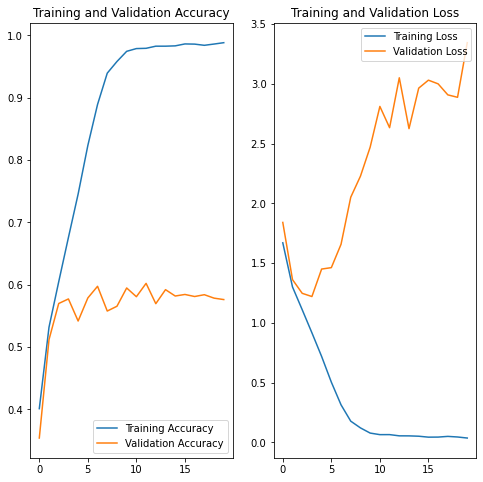

eval loss : 3.2879366874694824
eval accuracy : 0.5791000127792358


In [22]:
plot_train(gn_c[1])
print_evaluate(gn_c[2])

In [16]:
gn_c[1]

{'loss': [5.159670718312263,
  4.047407910823822,
  3.478517858982086,
  2.9189462900161742,
  2.349546332359314,
  1.7386802551150322,
  1.1853401140868665,
  0.7519613755494357,
  0.5143353694677353,
  0.34173572789877654,
  0.2702983340062201,
  0.24714020440354945,
  0.20530743782408536,
  0.1880249859392643,
  0.17288294866681098,
  0.15144296818878503,
  0.14266803415957838,
  0.15229081326397137,
  0.13991514692548662,
  0.11180766671895981],
 'out1_accuracy': [0.357275,
  0.49925,
  0.5717,
  0.6353,
  0.697325,
  0.7609,
  0.824625,
  0.876625,
  0.91335,
  0.941825,
  0.955925,
  0.961525,
  0.968475,
  0.973325,
  0.976875,
  0.978525,
  0.98075,
  0.9806,
  0.982475,
  0.98605],
 'out1_loss': [1.7781549,
  1.3937002,
  1.2104623,
  1.0350621,
  0.8657355,
  0.6848575,
  0.51557124,
  0.36613038,
  0.258726,
  0.17894402,
  0.13649659,
  0.11738256,
  0.09564721,
  0.08266061,
  0.07326751,
  0.065483734,
  0.05921389,
  0.058547374,
  0.0548601,
  0.04446083],
 'out2_accura